## Visualização dos dados - interativos

Nesse notebook são feitos os protótipos da visualizações interativas dos dados

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from utils.load_csv import load_csv
from utils.load_shp import load_shp
from utils.save_graph import save_graph

In [2]:
df_ppa_reg = load_csv("ppa_reg.csv")

gdf_subprefs = load_shp("subprefs.shp")

#### Visualização 1

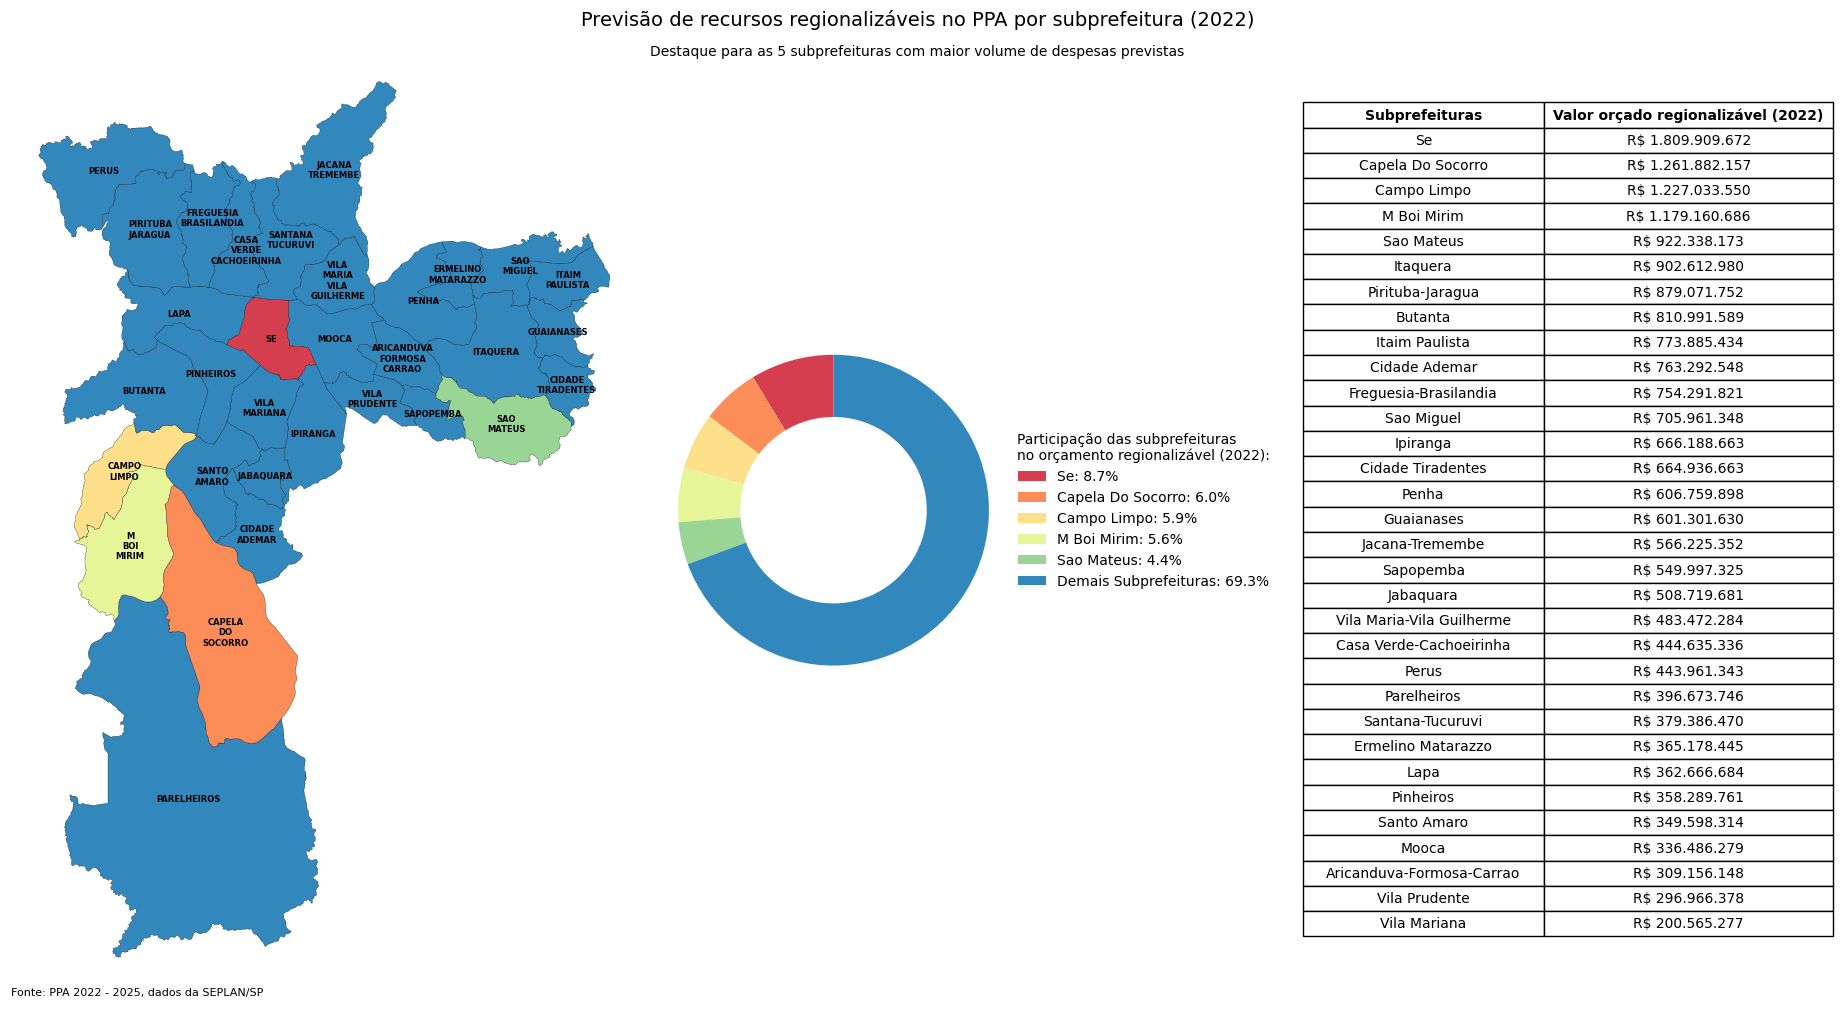

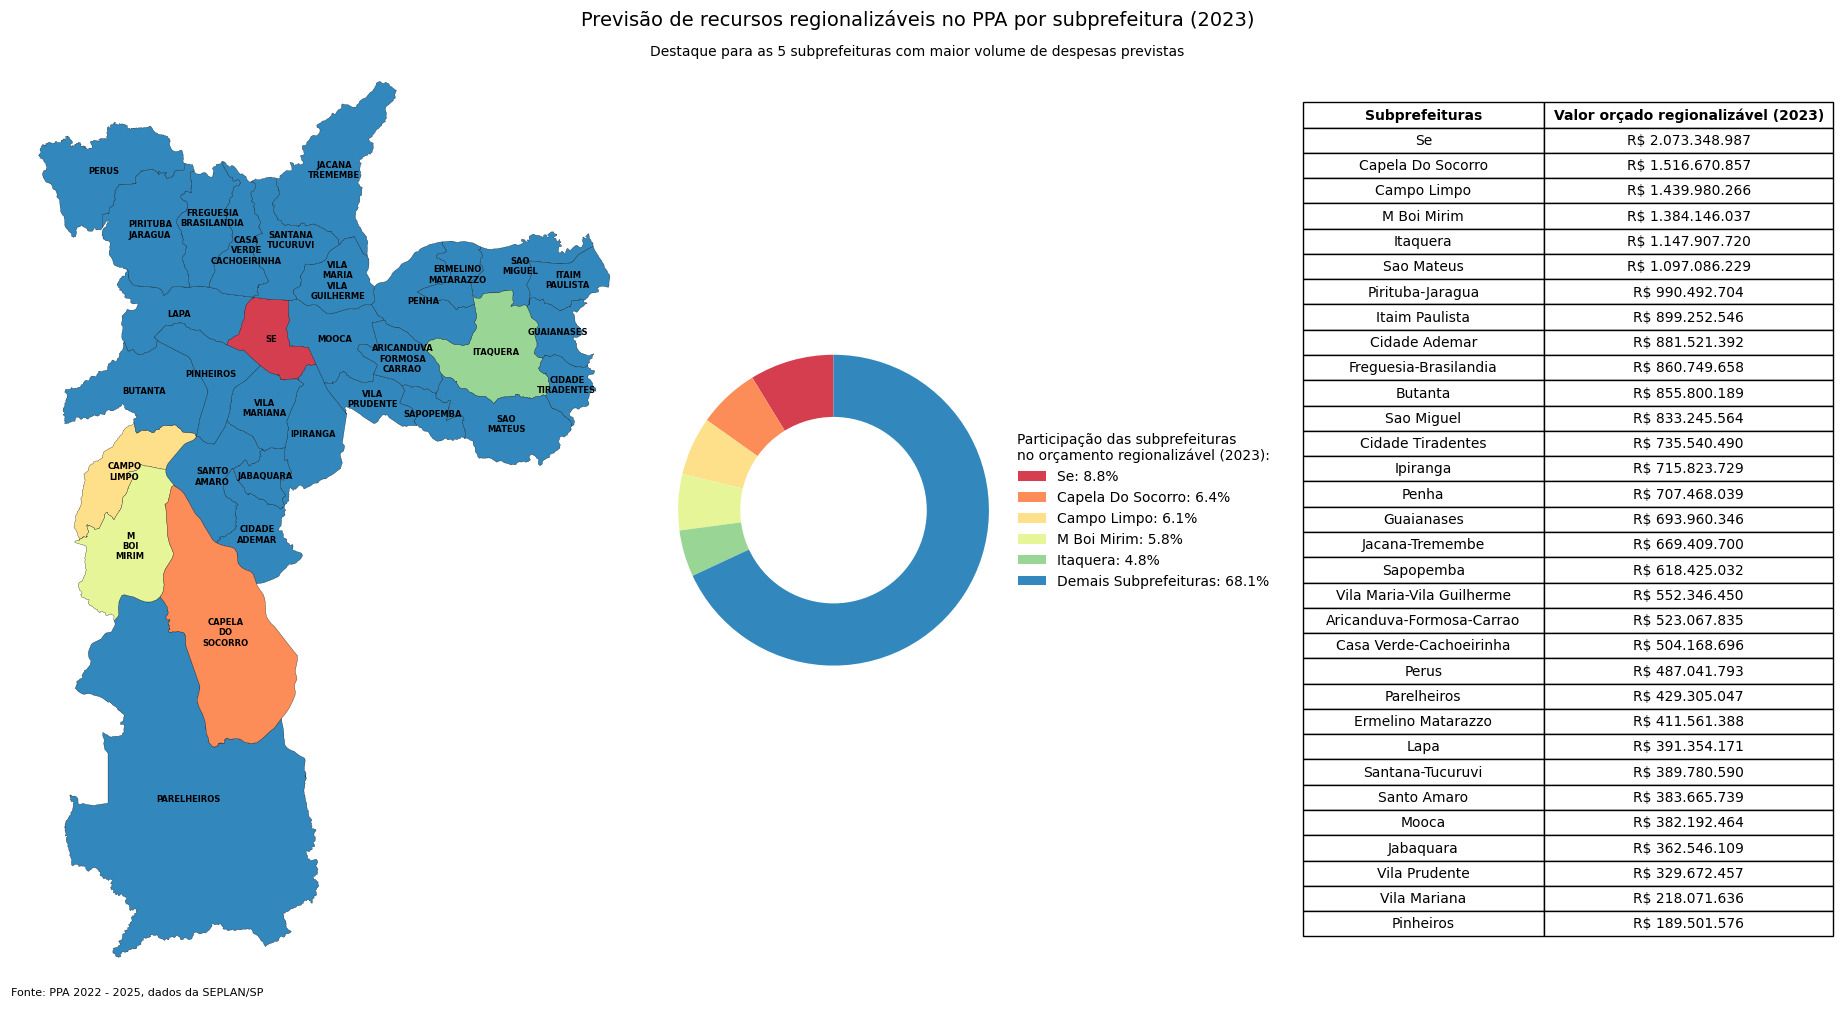

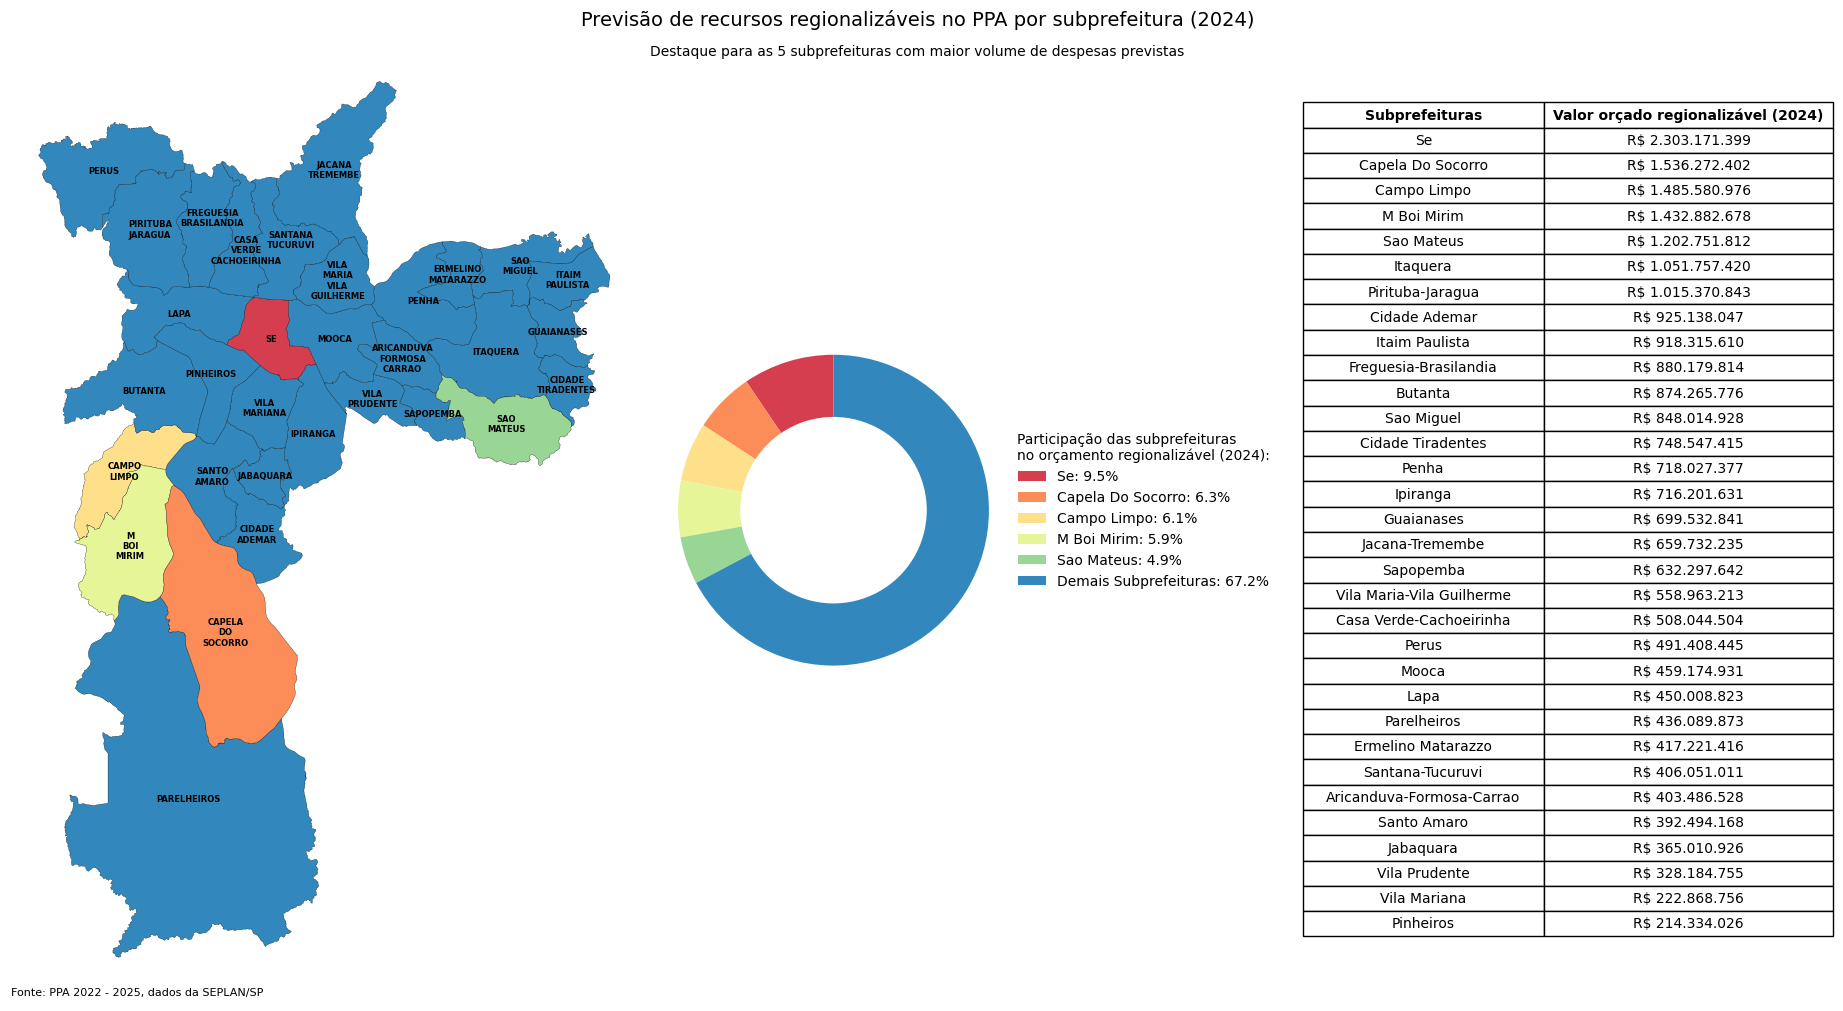

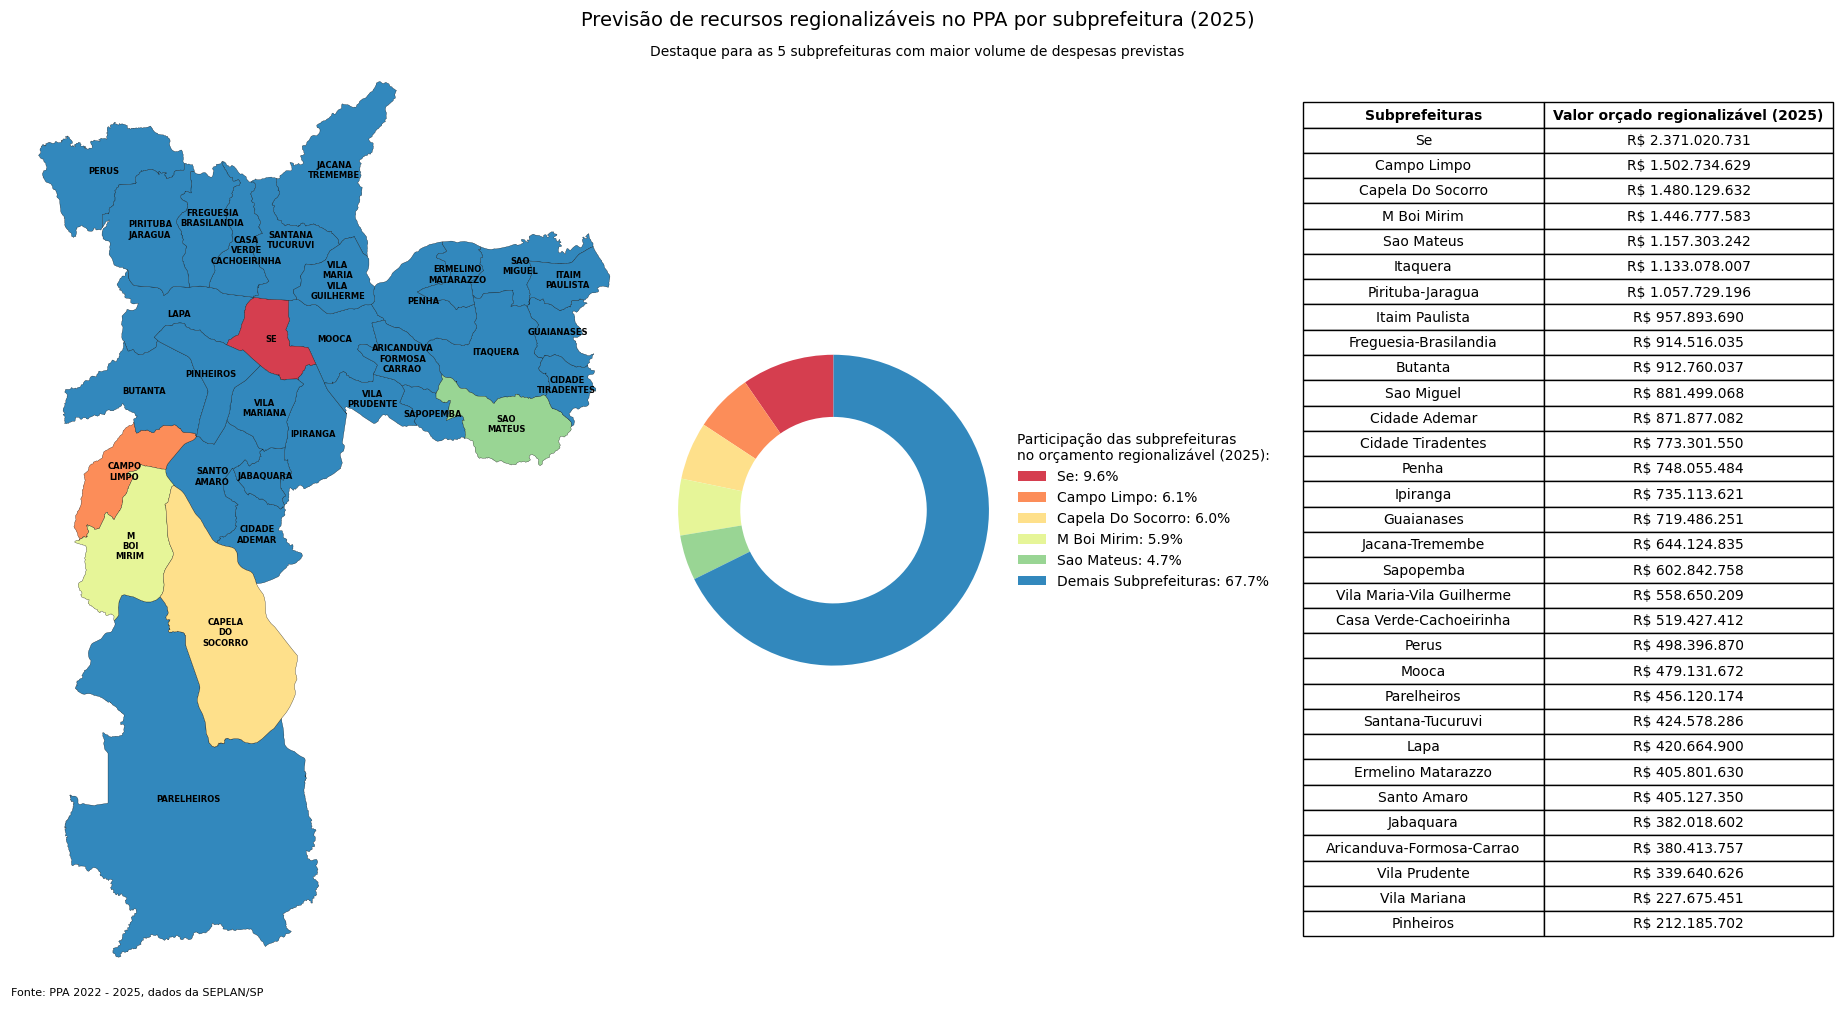

In [3]:
def gerar_interativo1_por_ano(ano):

    df_grouped_mapas = df_ppa_reg.groupby("descricao prefeitura regional")[[f"valor {ano}"]].sum().reset_index()

    gdf_mapa = gdf_subprefs.merge(df_grouped_mapas, 
                                  how = "left", 
                                  left_on = "nm_subpref", 
                                  right_on = "descricao prefeitura regional")

    gdf_mapa["centroid"] = gdf_mapa.geometry.centroid

    deslocamentos = {"FREGUESIA-BRASILANDIA": (500, 500),
                     "CASA VERDE-CACHOEIRINHA": (500, -500),
                     "SANTANA-TUCURUVI": (500, 500)}

    gdf_mapa["desloc_x"] = gdf_mapa.apply(lambda row: row["centroid"].x + deslocamentos.get(row["nm_subpref"], (0, 0))[0], axis = 1)

    gdf_mapa["desloc_y"] = gdf_mapa.apply(lambda row: row["centroid"].y + deslocamentos.get(row["nm_subpref"], (0, 0))[1], axis = 1)

    gdf_mapa["percentual"] = gdf_mapa[f"valor {ano}"] / gdf_mapa[f"valor {ano}"].sum() * 100

    gdf_mapa_sorted = gdf_mapa.sort_values(f"valor {ano}", ascending = False)

    top5 = gdf_mapa_sorted.iloc[:5]

    outros = pd.DataFrame({"nm_subpref": ["Demais subprefeituras"],
                           f"valor {ano}": [gdf_mapa_sorted.iloc[5:][f"valor {ano}"].sum()],
                           "percentual": [gdf_mapa_sorted.iloc[5:][f"valor {ano}"].sum() / gdf_mapa[f"valor {ano}"].sum() * 100]})

    plot_df = pd.concat([top5[["nm_subpref", f"valor {ano}", "percentual"]], outros], ignore_index = True)

    colors = ["#d53e4f", "#fc8d59", "#fee08b", "#e6f598", "#99d594", "#3288bd"]
    
    color_map = dict(zip(plot_df["nm_subpref"], colors))

    gdf_mapa["grupo_cor"] = gdf_mapa["nm_subpref"].where(gdf_mapa["nm_subpref"].isin(top5["nm_subpref"]), "Demais subprefeituras")

    gdf_mapa["cor"] = gdf_mapa["grupo_cor"].map(color_map)

    fig, (ax_map, ax_pie, ax_table) = plt.subplots(1, 3, figsize = (20, 10), 
                                                   gridspec_kw = {"width_ratios": [2, 1, 1]}, 
                                                   constrained_layout = True)

    bbox = ax_pie.get_position()

    ax_pie.set_position([bbox.x0 - 0.1, bbox.y0, bbox.width, bbox.height])

    gdf_mapa.plot(color = gdf_mapa["cor"],
                  linewidth = 0.2,
                  edgecolor = "black",
                  ax = ax_map)

    for _, row in gdf_mapa.iterrows():
        nome = "\n".join(row["nm_subpref"].replace("-", " ").split())
        ax_map.text(row["desloc_x"], row["desloc_y"],
                    nome,
                    fontsize = 6,
                    ha = "center",
                    va = "center",
                    fontweight = "bold",
                    color = "black")

    ax_map.axis("off")

    wedges, texts = ax_pie.pie(plot_df[f"valor {ano}"],
                               labels = None,
                               startangle = 90,
                               colors = colors,
                               wedgeprops = dict(width = 0.4))

    legend_labels = [f'{row["nm_subpref"].title()}: {row["percentual"]:.1f}%' for _, row in plot_df.iterrows()]

    legend = ax_pie.legend(wedges, 
                           legend_labels,
                           title = f"Participação das subprefeituras\nno orçamento regionalizável ({ano}):",
                           loc = "center left",
                           bbox_to_anchor = (1, 0.5),
                           fontsize = 10)

    legend.get_frame().set_linewidth(0)

    legend.get_frame().set_facecolor("none")

    ax_pie.axis("equal")

    gdf_mapa_sorted["valor_fmt"] = gdf_mapa_sorted[f"valor {ano}"].apply(lambda x: f"R$ {x:,.0f}".replace(",", "."))

    table_data = []
    for _, row in gdf_mapa_sorted.iterrows():
        nome_formatado = row["nm_subpref"].title()
        table_data.append([nome_formatado, row["valor_fmt"]])

    table_df = pd.DataFrame(table_data, columns=["Subprefeituras", f"Valor orçado regionalizável ({ano})"])

    ax_table.axis("off")
    table = ax_table.table(cellText = table_df.values,
                           colLabels = table_df.columns,
                           cellLoc = "left",
                           colLoc = "left",
                           loc = "center",
                           colWidths = [0.5, 0.6])

    table.auto_set_font_size(False)

    table.set_fontsize(10)
    
    table.scale(1, 1.5)

    for i in range(len(table_df)):
        for j in range(2): 
            table[(i+1, j)].set_facecolor("white")
            table[(i+1, j)].set_text_props(color = "black", fontweight = "normal", ha = "center")

    for j in range(2):
        table[(0, j)].set_text_props(fontweight = "bold", ha = "center")
        table[(0, j)].set_facecolor("white")

    fig.suptitle(f"Previsão de recursos regionalizáveis no PPA por subprefeitura ({ano})", fontsize = 14, x = 0.54)

    fig.text(0.54, 0.95, "Destaque para as 5 subprefeituras com maior volume de despesas previstas", 
             ha = "center", fontsize = 10)

    plt.figtext(0.15, 0.01, "Fonte: PPA 2022 - 2025, dados da SEPLAN/SP", ha = "center", fontsize = 8)

    plt.show()

    save_graph(fig, f"interativo_1_{ano}.png")

for ano in [2022, 2023, 2024, 2025]:
    gerar_interativo1_por_ano(ano)